<a href="https://colab.research.google.com/github/kartthik-18/Bitcoin-Price-Predictor-using-LSTM-Neural-Networks-/blob/main/Bitcoin_Price_Predictor_using_LSTM_Neural_Networks_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First we will import the necessary Library

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
maindf = pd.read_csv('btc.csv')

In [ ]:
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Total number of days present in the dataset:  2713
Total number of fields present in the dataset:  7


In [ ]:
maindf.shape

(2713, 7)

In [ ]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
maindf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2708,2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125,44575.203125,22721659051
2709,2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375,43961.859375,19792547657
2710,2022-02-17,43937.070313,44132.972656,40249.371094,40538.011719,40538.011719,26246662813
2711,2022-02-18,40552.132813,40929.152344,39637.617188,40030.976563,40030.976563,23310007704
2712,2022-02-19,40022.132813,40246.027344,40010.867188,40126.429688,40126.429688,22263900160


In [ ]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 148.5+ KB


In [ ]:
maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [ ]:
print('Null Values:',maindf.isnull().values.sum())

Null Values: 0


In [ ]:
# Lets First Take all the Close Price
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2713, 2)


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2014-2022', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(2713, 1)


In [ ]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1627, 1)
test_data:  (1086, 1)


In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1566, 60)
y_train:  (1566,)
X_test:  (1025, 60)
y_test (1025,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1566, 60, 1)
X_test:  (1025, 60, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense


model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=150,batch_size=32,verbose=1)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 1.4603e-04 - val_loss: 0.0041
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 1.5388e-04 - val_loss: 0.0064
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 1.1258e-04 - val_loss: 0.0065
Epoch 5/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 1.2177e-04 - val_loss: 0.0037
Epoch 6/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 1.4011e-04 - val_loss: 0.0043
Epoch 7/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 9.9545e-05 - val_loss: 0.0028
Epoch 8/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 1.0470e-04 - val_loss: 0.0064
Epoch 9/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - loss: 1.3706e-04 - val_loss: 0.0034
Epoch 10/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 9.4745e-05 - val_loss: 0.0054
Epoch 11/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 1.0435e-04 - val_loss: 0.0075
Epoch 12/

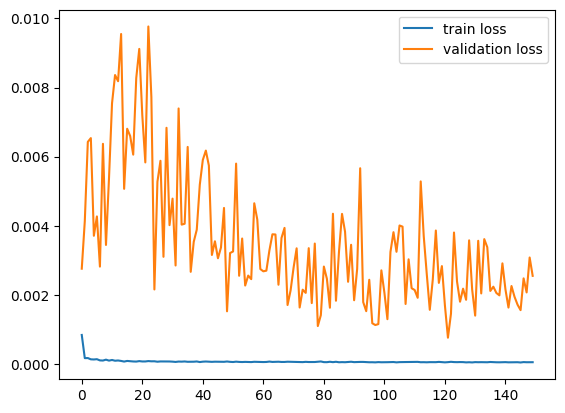

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
#Doing prediction and checking performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


((1566, 1), (1025, 1))

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(original_ytest, test_predict))
mae = mean_absolute_error(original_ytest, test_predict)
r2 = r2_score(original_ytest, test_predict)

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R² Score: {r2}")

Test RMSE: 3401.608632904316
Test MAE: 2065.0439320185365
Test R² Score: 0.9681980644108392


In [ ]:
# Select a few samples from the test set to show inputs and predictions
n_samples_to_show = 5

for i in range(n_samples_to_show):
    input_sequence = X_test[i].reshape(1, time_step, 1)
    prediction = model.predict(input_sequence, verbose=0)

    # Inverse transform the prediction and actual value
    predicted_price = scaler.inverse_transform(prediction)[0][0]
    actual_price = scaler.inverse_transform(y_test[i].reshape(-1, 1))[0][0]

    # Show the last few input values (already scaled, but we inverse them for clarity)
    input_prices = scaler.inverse_transform(X_test[i].reshape(-1, 1)).flatten()

    print(f"\nSample {i+1}:")
    print("Input closing prices (last 5 of 60):", np.round(input_prices[-5:], 2))
    print("Predicted next closing price       :", round(predicted_price, 2))
    print("Actual next closing price          :", round(actual_price, 2))



Sample 1:
Input closing prices (last 5 of 60): [5279.35 5268.29 5285.14 5247.35 5350.73]
Predicted next closing price       : 5361.87
Actual next closing price          : 5402.7

Sample 2:
Input closing prices (last 5 of 60): [5268.29 5285.14 5247.35 5350.73 5402.7 ]
Predicted next closing price       : 5421.48
Actual next closing price          : 5505.28

Sample 3:
Input closing prices (last 5 of 60): [5285.14 5247.35 5350.73 5402.7  5505.28]
Predicted next closing price       : 5510.64
Actual next closing price          : 5768.29

Sample 4:
Input closing prices (last 5 of 60): [5247.35 5350.73 5402.7  5505.28 5768.29]
Predicted next closing price       : 5724.7
Actual next closing price          : 5831.17

Sample 5:
Input closing prices (last 5 of 60): [5350.73 5402.7  5505.28 5768.29 5831.17]
Predicted next closing price       : 5838.43
Actual next closing price          : 5795.71
